In [1]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
options(future.globals.maxSize = 1000000 * 1024^2)
set.seed(2422012)

# Single cell libraries
library(Seurat)
library(sctransform)
library(rliger)
library(SeuratWrappers)
library(conos)
library(scater)
library(scDblFinder)
library(scran)
library(sctransform)
library(scry)

# Rest libraries
library(BiocParallel)
library(ggplot2)
library(dplyr)
library(cowplot)

library(scCustomize)
library(stringr)
library(dittoSeq)
library(DESeq2)
library(enrichR)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [3]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/"
datadir = projectdir + "Data/"
resultdir = projectdir + "Result/Feng_Figures/"
resultdirviolin = projectdir + "Result/Feng_Figures/Violins_Heatmaps/"

adata_file = 'AnnData_Integrated.h5ad'

In [4]:
%%R -i resultdir -i resultdirviolin
dir.create(resultdir)
dir.create(resultdirviolin)

In [5]:
%%R -i resultdir -i projectdir
# setwd(projectdir)

Subbbb <- readRDS("Subset_raarranged.rds")

In [5]:
%%R
DefaultAssay(Subbbb) <- "SCT"

# ====================== CCR7mCD45ROm ================================
seurat_CCR7mCD45ROm = subset(Subbbb, subset= CellType =="CCR7mCD45ROm")
seurat_CCR7mCD45ROm<- SetIdent(seurat_CCR7mCD45ROm , value = "Condition")
seurat_CCR7mCD45ROm <- PrepSCTFindMarkers(seurat_CCR7mCD45ROm)

# ====================== CCR7mCD45ROp ================================
seurat_CCR7mCD45ROp = subset(Subbbb, subset= CellType =="CCR7mCD45ROp")
seurat_CCR7mCD45ROp<- SetIdent(seurat_CCR7mCD45ROp , value = "Condition")
seurat_CCR7mCD45ROp <- PrepSCTFindMarkers(seurat_CCR7mCD45ROp)

# ====================== CCR7pCD45ROm ================================
seurat_CCR7pCD45ROm = subset(Subbbb, subset= CellType =="CCR7pCD45ROm")
seurat_CCR7pCD45ROm<- SetIdent(seurat_CCR7pCD45ROm , value = "Condition")
seurat_CCR7pCD45ROm <- PrepSCTFindMarkers(seurat_CCR7pCD45ROm)

# ====================== CCR7pCD45ROp ================================
seurat_CCR7pCD45ROp = subset(Subbbb, subset= CellType =="CCR7pCD45ROp")
seurat_CCR7pCD45ROp<- SetIdent(seurat_CCR7pCD45ROp , value = "Condition")
seurat_CCR7pCD45ROp <- PrepSCTFindMarkers(seurat_CCR7pCD45ROp)

In [6]:
%%R
avg_SCT_cl <- AverageExpression(Subbbb,group.by="Combined",return.seurat = T)
avg_SCT_cl$Cluster <- as.vector(unlist(lapply(colnames(avg_SCT_cl),function(x){str_split(x,pattern="_")[[1]][1]})))
avg_SCT_cl$Condition <- unlist(lapply(colnames(avg_SCT_cl),function(x){str_split(x,pattern="_")[[1]][2]}))



In [7]:
%%R
avg_SCT_cl$Cluster

[1] " CD45RO-CCR7-" " CD45RO-CCR7+" " CD45RO+CCR7-" " CD45RO+CCR7+"
[5] " CD45RO-CCR7-" " CD45RO-CCR7+" " CD45RO+CCR7-" " CD45RO+CCR7+"


In [8]:
%%R
levels(Subbbb$CCellType)
avg_SCT_cl$Cluster <- factor(avg_SCT_cl$Cluster,
    levels=c(" CD45RO-CCR7+", " CD45RO+CCR7+", " CD45RO+CCR7-", " CD45RO-CCR7-"))
avg_SCT_cl$Cluster

[1] 4 1 3 2 4 1 3 2


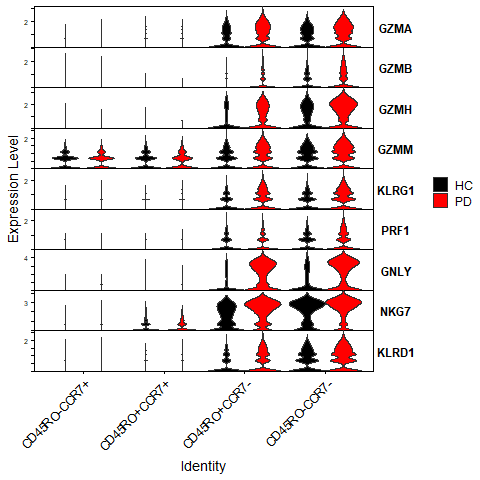

In [14]:
%%R -i  resultdirviolin
features <- c("GZMA", "GZMB", "GZMH", "GZMM", "KLRG1", "PRF1", "GNLY", "NKG7", "KLRD1")
Idents(Subbbb) <- "CCellType"

p <- VlnPlot(Subbbb, features,stack=T,split.by="Condition",cols=c("black","red"),flip =T)

pdf(paste0(resultdirviolin,
       "Violin_GZMA_GZMB_GZMH_GZMM_KLRG1_PRF1_GNLY_NKG7_KLRD1.pdf"))
plot(p)
dev.off()
p 

## Violin plots
Following genes GZMA, GZMB, GZMH, GZMK, GZMM, PRF1, GNLY, NKG7, KLRD1

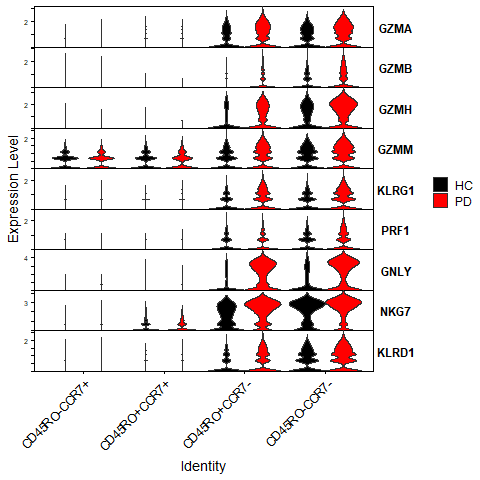

In [10]:
%%R
features <- c("GZMA", "GZMB", "GZMH", "GZMM", "KLRG1", "PRF1", "GNLY", "NKG7", "KLRD1")
Idents(Subbbb) <- "CCellType"
VlnPlot(Subbbb, features,stack=T,split.by="Condition",cols=c("black","red"),flip =T)

pdf(paste0(resultdirviolin,
       "Violin_GZMA_GZMB_GZMH_GZMM_KLRG1_PRF1_GNLY_NKG7_KLRD1.pdf"))
plot(p)
dev.off()
p 

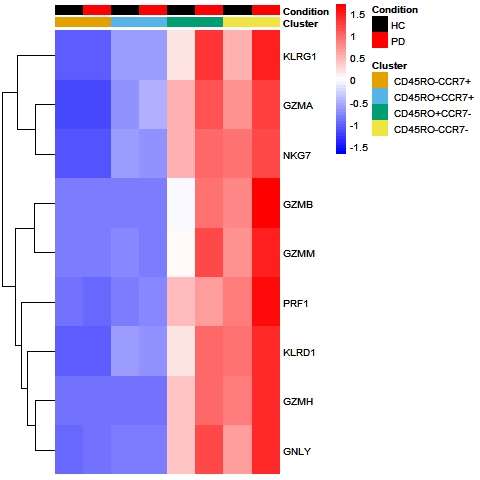

In [21]:
%%R
p <- dittoHeatmap(avg_SCT_cl,features,
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,
       "Heatmap_GZMA_GZMB_GZMH_GZMM_KLRG1_PRF1_GNLY_NKG7_KLRD1.pdf"))
print(p)
dev.off()
p 

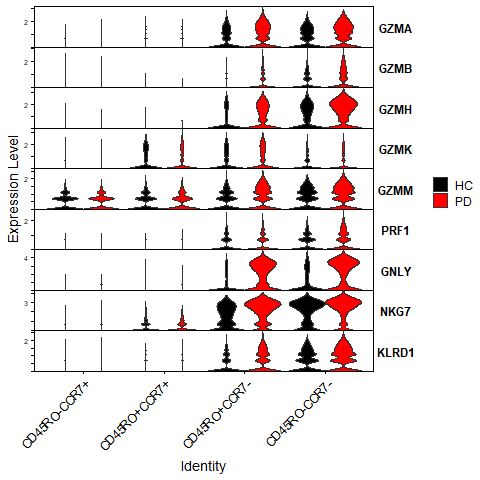

In [22]:
%%R
features <- c("GZMA", "GZMB", "GZMH", "GZMK", "GZMM", "PRF1", "GNLY", "NKG7", "KLRD1")
Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, features,stack=T,split.by="Condition",cols=c("black","red"),flip =T)


pdf(paste0(resultdirviolin,
       "Violin_GZMA_GZMB_GZMH_GZMK_GZMM_PRF1_GNLY_NKG7_KLRD1.pdf"))
plot(p)
dev.off()
p 

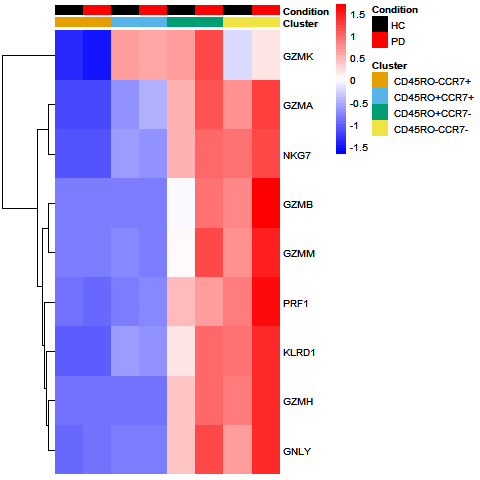

In [23]:
%%R
p <- dittoHeatmap(avg_SCT_cl,features,
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)


pdf(paste0(resultdirviolin,
       "Heatmap_GZMA_GZMB_GZMH_GZMK_GZMM_PRF1_GNLY_NKG7_KLRD1.pdf"))
print(p)
dev.off()
p 

## Volin plot and heatmap 
For ALL the below genes from CCR7mCD45ROm cell KEGG POS pathway analysis:

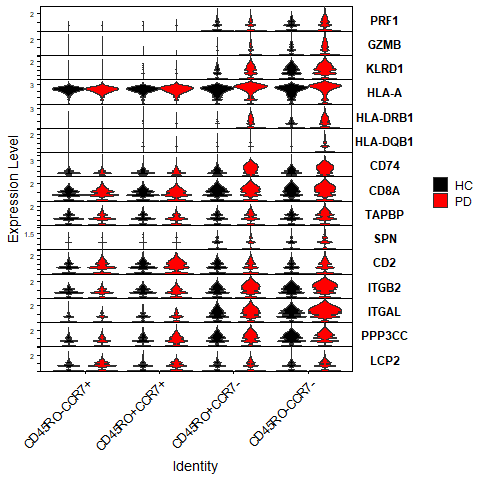

In [24]:
%%R 
# removed HLA-DRA, HLA-DQA1, PTPRM
graft <- c("PRF1","GZMB","KLRD1","HLA-A","HLA-DRB1","HLA-DQB1")
antigen <- c("CD74","CD8A","KLRD1","HLA-A","HLA-DRB1","TAPBP","HLA-DQB1")
celladhension <- c("SPN","CD2","CD8A","ITGB2","HLA-A","ITGAL","HLA-DRB1","HLA-DQB1")
allograft <- c("PRF1","GZMB","HLA-A","HLA-DRB1","HLA-DQB1")
autoimmune <- c("PRF1","GZMB","HLA-A","HLA-DRB1","HLA-DQB1")
nkdeat <- c("PPP3CC","ITGB2","PRF1","GZMB","KLRD1","LCP2","HLA-A","ITGAL")
features <- unique(c(graft,antigen,celladhension,allograft,autoimmune,nkdeat))

Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, features,stack=T,split.by="Condition",cols=c("black","red"),flip =T)



pdf(paste0(resultdirviolin,
       "Violin_selected_basedon_pathways.pdf"))
plot(p)
dev.off()
p 

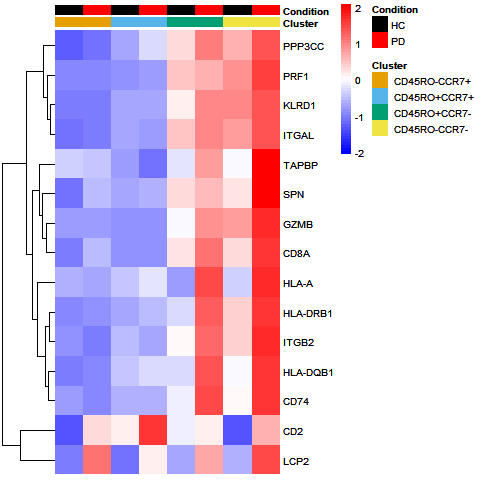

In [25]:
%%R
p <- dittoHeatmap(avg_SCT_cl,features,
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,
       "Heatmap_selected_basedon_pathways.pdf"))
print(p)
dev.off()
p 

## Violin plot/heatmap 
For those genes obtained from CCR7pCD45ROm KEGG POS and Reactome POS pathway analysis:
PTPRC;PIK3CD;CD3G;LCP2;PRKCQ;CARD11; RUNX1; RUNX2;

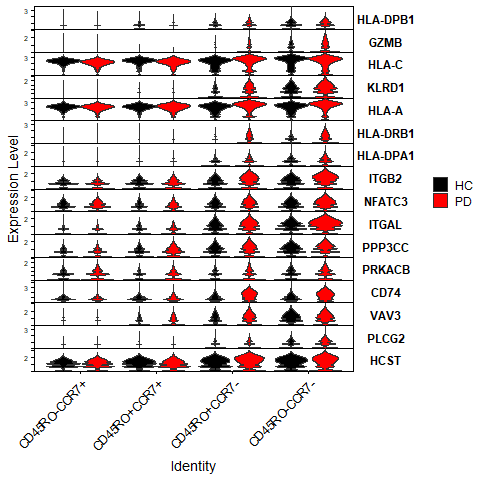

In [28]:
%%R
# HLA-DRA, HLA-DQA1, HLA-DQB1, ADCY9, PTPRM
graft <- c("HLA-DPB1","GZMB","HLA-C","KLRD1","HLA-A","HLA-DRB1","HLA-DPA1")
allograft <- c("HLA-DPB1","GZMB","HLA-C","HLA-A","HLA-DRB1","HLA-DPA1")
typeI <- c("HLA-DPB1","GZMB","HLA-C","HLA-A","HLA-DRB1","HLA-DPA1")
hummant <- c("ITGB2","NFATC3","HLA-C","HLA-A","ITGAL","PPP3CC","HLA-DPB1","PRKACB","HLA-DRB1","HLA-DPA1")
antigen <- c("CD74","HLA-DPB1","HLA-C","KLRD1","HLA-A","HLA-DRB1","HLA-DPA1")
autimmune <- c("HLA-DPB1","HLA-C","GZMB","HLA-A","HLA-DRB1","HLA-DPA1")
celladjension <- c("ITGB2","HLA-DPB1","HLA-C","HLA-A","ITGAL","HLA-DRB1","HLA-DPA1")
NKcell <- c("VAV3","PPP3CC","ITGB2","PLCG2","HLA-C","GZMB","KLRD1","HLA-A","ITGAL","HCST")

features <- unique(c(graft,allograft,typeI,hummant,
    antigen,autimmune,celladjension,NKcell))

Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, features,stack=T,split.by="Condition",cols=c("black","red"),flip =T)

pdf(paste0(resultdirviolin,
       "Violin_selected_basedon_pathways2.pdf"))
print(p)
dev.off()
p 

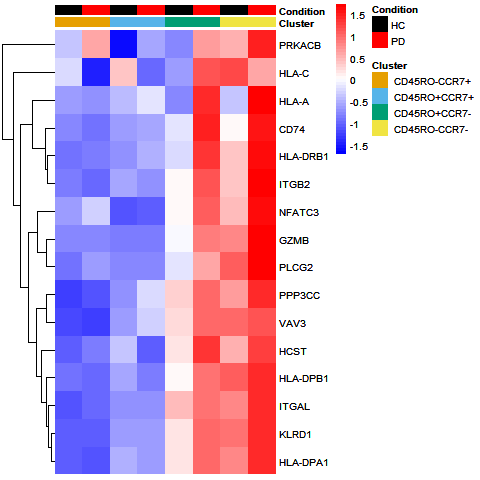

In [29]:
%%R
p<- dittoHeatmap(avg_SCT_cl,features,
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)
pdf(paste0(resultdirviolin,
       "Heatmap_selected_basedon_pathways2.pdf"))
print(p)
dev.off()
p 

## The REACTOME POS pathway is 
“RUNX1 Regulates Transcription Of Genes Involved In Differentiation Of Myeloid Cells R-HSA-8939246”
The KEGG POS pahway is “T cell receptor signaling pathway”

 

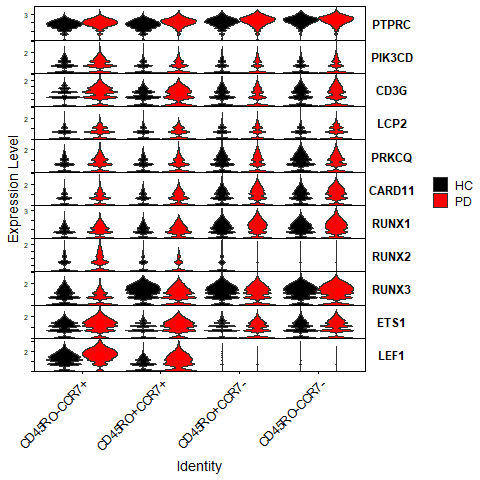

In [30]:
%%R
RUNX1_TcellRecept  <- c("PTPRC","PIK3CD","CD3G","LCP2","PRKCQ",
    "CARD11", "RUNX1", "RUNX2","RUNX3", "ETS1", "LEF1")
Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, features=RUNX1_TcellRecept,stack=T,split.by="Condition",cols=c("black","red"),flip =T)

pdf(paste0(resultdirviolin,
       "Violin_reactomepos.pdf"))
print(p)
dev.off()
p 

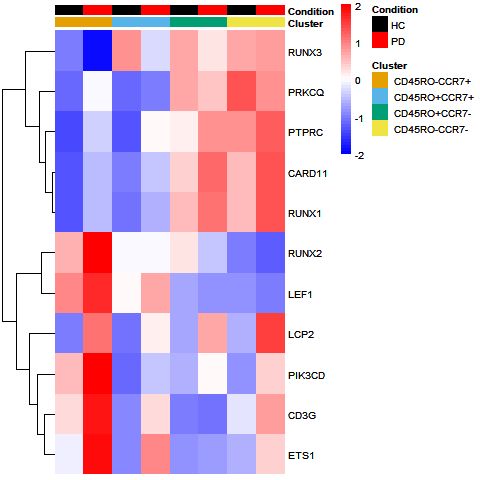

In [31]:
%%R
p<- dittoHeatmap(avg_SCT_cl,RUNX1_TcellRecept,
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,
       "Heatmap_reactomepos.pdf"))
print(p)
dev.off()
p 

## CCR7pCD45ROm
# CCR7pCD45ROp

In [20]:
# prosimo fold change * -log10pvalue = tstat



In [32]:
%%R -i projectdir
resultdir = paste0(projectdir, "Result/Differnetial_Expression_pct_01/")
CCR7pCD45ROm_pos_degs <- read.csv(paste0(resultdir,"CCR7pCD45ROm/CCR7pCD45ROmDEG_MinPct_0.3.csv"))
CCR7pCD45ROp_pos_degs <- read.csv(paste0(resultdir,"CCR7pCD45ROp/CCR7pCD45ROpDEG_MinPct_0.3.csv"))

rownames(CCR7pCD45ROm_pos_degs) <- CCR7pCD45ROm_pos_degs$gene
rownames(CCR7pCD45ROp_pos_degs) <- CCR7pCD45ROp_pos_degs$gene


In [33]:
%%R
CCR7pCD45ROm_pos_degs[1:5,]

             gene     tstat gene.score p_val p_val_adj diff.pct
HIST1H1E HIST1H1E  91.55809    1.33506     0         0    0.238
HIST1H1D HIST1H1D  66.08165    0.93616     0         0    0.209
HIST1H1C HIST1H1C  54.13309    0.84689     0         0    0.183
CARMIL1   CARMIL1  39.85066    0.75566     0         0    0.156
LEF1         LEF1 138.42348    0.73703     0         0    0.069
         enrichment.ratio pct.1 pct.2 avg_log2FC cluster gene.name
HIST1H1E          2.59730 0.387 0.149    0.51402      PD  HIST1H1E
HIST1H1D          1.96758 0.425 0.216    0.47579      PD  HIST1H1D
HIST1H1C          1.82805 0.404 0.221    0.46327      PD  HIST1H1C
CARMIL1           2.01959 0.309 0.153    0.37417      PD   CARMIL1
LEF1              1.07761 0.958 0.889    0.68395      PD      LEF1
              ensembl.id HC_counts PD_counts   HC_norm   PD_norm
HIST1H1E ENSG00000168298 0.2552629 0.8043740 0.1596922 0.5159840
HIST1H1D ENSG00000124575 0.3859099 0.8810387 0.2472903 0.5770848
HIST1H1C ENSG000001

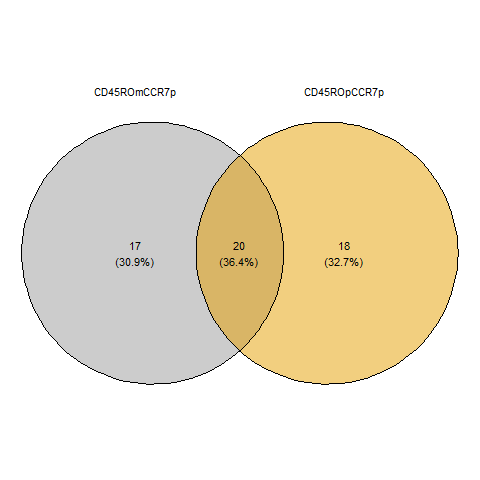

In [89]:
%%R -i resultdirviolin
library(ggvenn)
x <- list( 
    CD45ROmCCR7p = rownames(CCR7pCD45ROm_pos_degs %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    CD45ROpCCR7p = rownames(CCR7pCD45ROp_pos_degs %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05))
)
p <- ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )

pdf(paste0(resultdirviolin,"Venn_DEG_pct03_Allreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

[1] 55


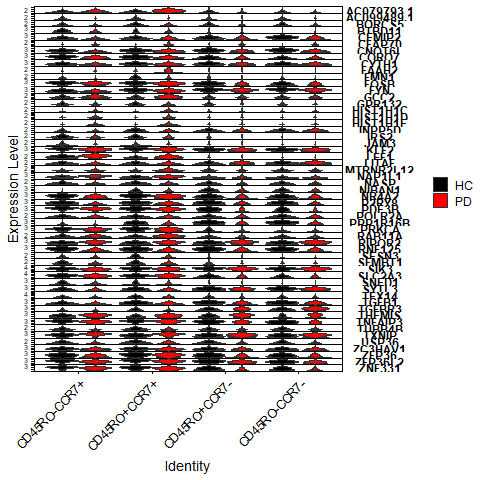

In [90]:
%%R
# remove HSPA1B and DLEU1

Allcommon <- Reduce(union,x)
print(length(Allcommon))
rest_Allcommon <- Allcommon[! Allcommon %in% c("HSPA1B","DLEU1")]
Idents(Subbbb) <- "CCellType"

p <- VlnPlot(Subbbb, sort(rest_Allcommon),stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,"Violin_DEG_pct03_Allreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"),height=12)
print(p)
dev.off()
p 

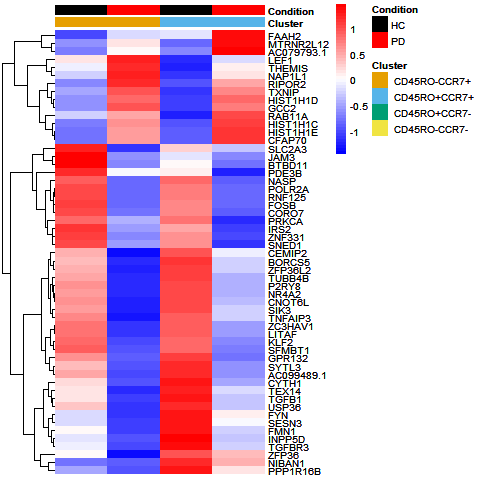

In [91]:
%%R
p <- dittoHeatmap(avg_SCT_cl,rest_Allcommon,cells.use = c(2,4,6,8),
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,"Heatmap_DEG_pct03_Allreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

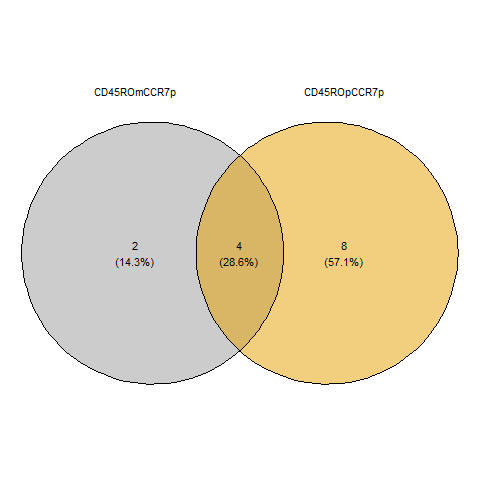

In [92]:
%%R -i resultdirviolin
library(ggvenn)
x <- list( 
    CD45ROmCCR7p = rownames(CCR7pCD45ROm_pos_degs %>% filter(avg_log2FC>0.5 &  p_val_adj <0.05)),
    CD45ROpCCR7p = rownames(CCR7pCD45ROp_pos_degs %>% filter(avg_log2FC>0.5 &  p_val_adj <0.05))
)
p <- ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )

pdf(paste0(resultdirviolin,"Venn_DEG_pct03_Upreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

[1] 14


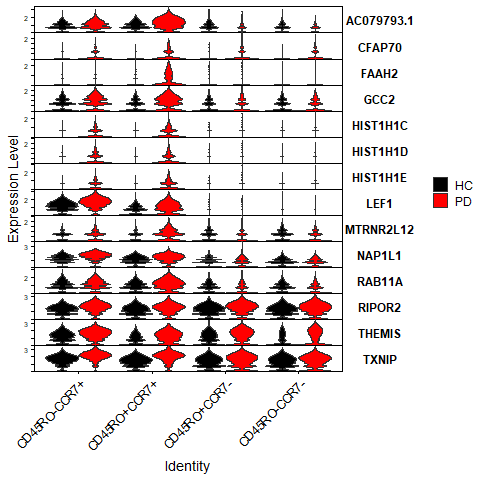

In [93]:
%%R
# remove HSPA1B and DLEU1

Allcommon <- Reduce(union,x)
print(length(Allcommon))
rest_Allcommon <- Allcommon[! Allcommon %in% c("HSPA1B","DLEU1")]
Idents(Subbbb) <- "CCellType"

p <- VlnPlot(Subbbb, sort(rest_Allcommon),stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,"Violin_DEG_pct03_Upreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

In [94]:
%%R
avg_SCT_cl@meta.data

                    orig.ident nCount_RNA nFeature_RNA nCount_SCT nFeature_SCT
 CD45RO-CCR7-_HC  CD45RO-CCR7-      10000        13223   4551.937        13224
 CD45RO-CCR7+_HC  CD45RO-CCR7+      10000        13220   4765.328        13220
 CD45RO+CCR7-_HC  CD45RO+CCR7-      10000        13223   4449.874        13224
 CD45RO+CCR7+_HC  CD45RO+CCR7+      10000        13224   4638.248        13224
 CD45RO-CCR7-_PD  CD45RO-CCR7-      10000        13223   4501.265        13223
 CD45RO-CCR7+_PD  CD45RO-CCR7+      10000        13219   4677.720        13219
 CD45RO+CCR7-_PD  CD45RO+CCR7-      10000        13223   4156.415        13223
 CD45RO+CCR7+_PD  CD45RO+CCR7+      10000        13217   4660.597        13217
                 nCount_integrated nFeature_integrated       Cluster Condition
 CD45RO-CCR7-_HC         480924737                2989  CD45RO-CCR7-        HC
 CD45RO-CCR7+_HC         394452349                2850  CD45RO-CCR7+        HC
 CD45RO+CCR7-_HC         285575033                29

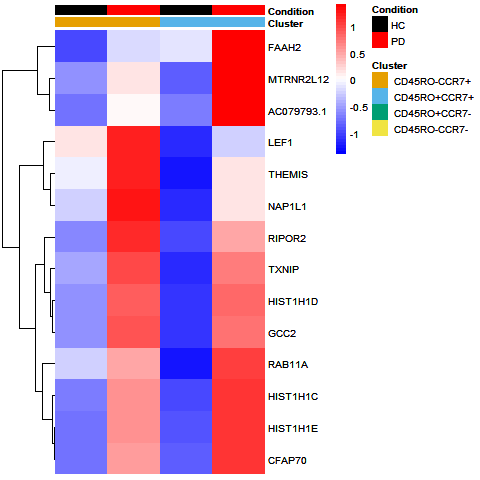

In [95]:
%%R

# ind <- which(avg_SCT_cl$Cluster %in%  c("CD45RO-CCR7+","CD45RO+CCR7+"))
# print(ind)
p <- dittoHeatmap(avg_SCT_cl,rest_Allcommon,cells.use = c(2,4,6,8),
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,"Heatmap_DEG_pct03_Upreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

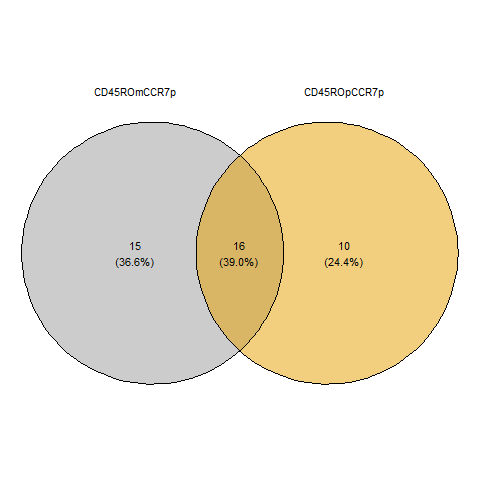

In [96]:
%%R
library(ggvenn)
x <- list( 
    CD45ROmCCR7p = rownames(CCR7pCD45ROm_pos_degs %>% filter(avg_log2FC < -0.5 &  p_val_adj <0.05)),
    CD45ROpCCR7p = rownames(CCR7pCD45ROp_pos_degs %>% filter(avg_log2FC < -0.5 &  p_val_adj <0.05))
)
p <- ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )

pdf(paste0(resultdirviolin,"Venn_DEG_pct03_Downreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

[1] 41


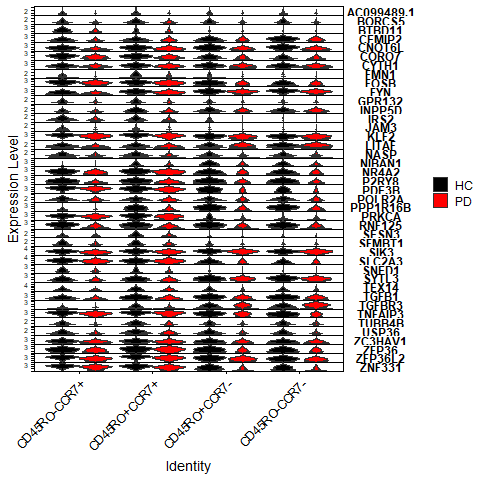

In [97]:
%%R
Allcommon <- Reduce(union,x)
print(length(Allcommon))
Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, sort(Allcommon),stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,"Violin_DEG_pct03_Downpreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"),height=12)
print(p)
dev.off()
p 

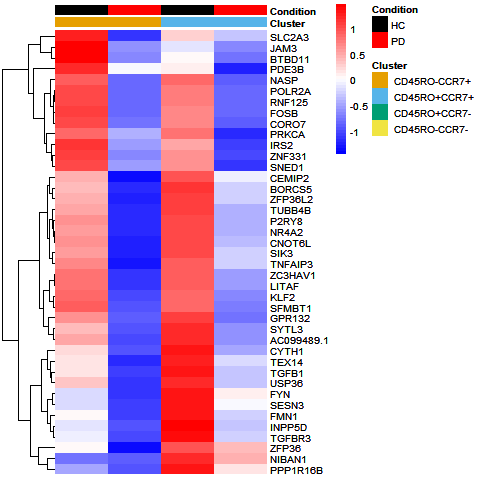

In [98]:
%%R
p<- dittoHeatmap(avg_SCT_cl,Allcommon,cells.use = c(2,4,6,8),
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,"Heatmap_DEG_pct03_Downpreg_CCR7pCD45ROm_CCR7pCD45ROp.pdf"))
print(p)
dev.off()
p 

# CCR7mCD45ROp
# CCR7mCD45ROm

In [99]:
%%R -i projectdir
resultdir = paste0(projectdir, "Result/Differnetial_Expression_pct_01/")
CCR7mCD45ROp_pos_degs <- read.csv(paste0(resultdir,"CCR7mCD45ROp/CCR7mCD45ROpDEG_MinPct_0.3.csv"))
CCR7mCD45ROm_pos_degs <- read.csv(paste0(resultdir,"CCR7mCD45ROm/CCR7mCD45ROmDEG_MinPct_0.3.csv"))

rownames(CCR7mCD45ROp_pos_degs) <- CCR7mCD45ROp_pos_degs$gene
rownames(CCR7mCD45ROm_pos_degs) <- CCR7mCD45ROm_pos_degs$gene

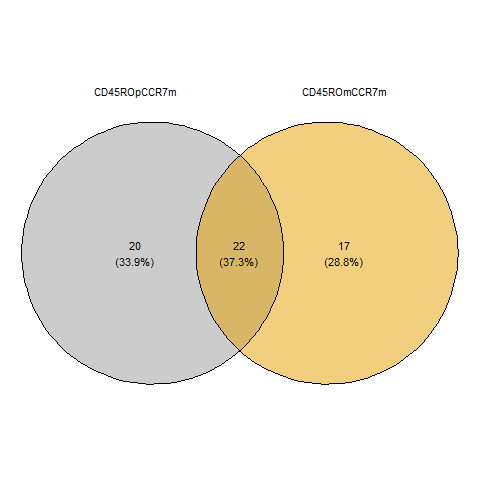

In [100]:
%%R
library(ggvenn)
x <- list( 
    CD45ROpCCR7m = rownames(CCR7mCD45ROp_pos_degs %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05)),
    CD45ROmCCR7m = rownames(CCR7mCD45ROm_pos_degs %>% filter(abs(avg_log2FC)>0.5 &  p_val_adj <0.05))
)
p<- ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )

pdf(paste0(resultdirviolin,"Venn_DEG_pct03_Allreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p 

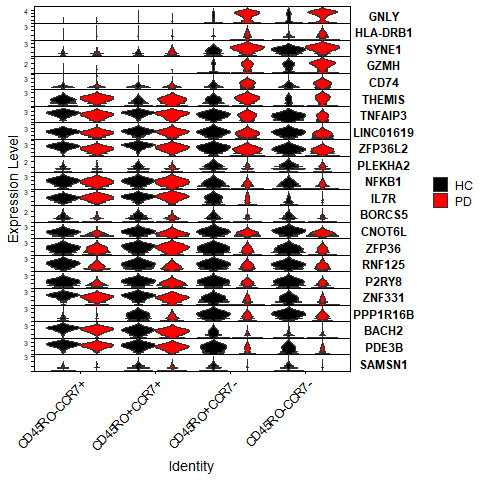

In [101]:
%%R
Allcommon <- Reduce(intersect,x)
Allcommon
Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, Allcommon,stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,"Violin_DEG_pct03_Allreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p

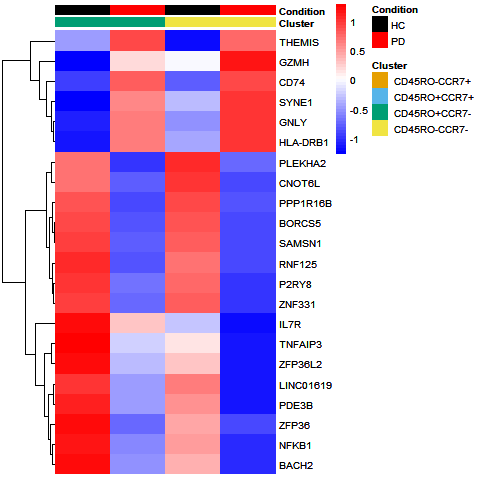

In [102]:
%%R
p<- dittoHeatmap(avg_SCT_cl,Allcommon,cells.use = c(1,3,5,7),
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,"Heatmap_DEG_pct03_Allreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p

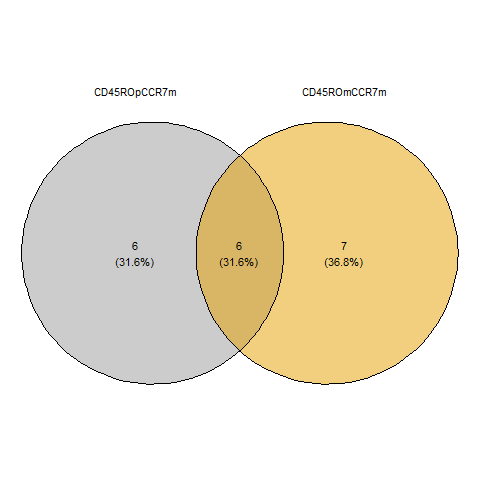

In [103]:
%%R
library(ggvenn)
x <- list( 
    CD45ROpCCR7m = rownames(CCR7mCD45ROp_pos_degs %>% filter(avg_log2FC > 0.5 &  p_val_adj <0.05)),
    CD45ROmCCR7m = rownames(CCR7mCD45ROm_pos_degs %>% filter(avg_log2FC > 0.5 &  p_val_adj <0.05))
)
p<- ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )

pdf(paste0(resultdirviolin,"Venn_DEG_pct03_Upreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p 

[1] 19


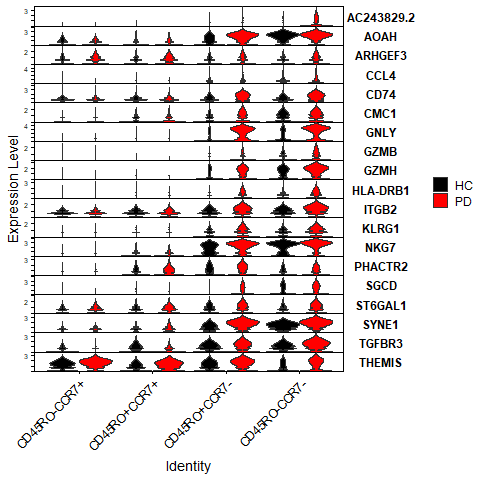

In [104]:
%%R
# remove AL392086.3
Allcommon <- Reduce(union,x)
rest_Allcommon <- Allcommon[! Allcommon %in% c("AL392086.3")]

print(length(rest_Allcommon))
Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, sort(rest_Allcommon),stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,"Violin_DEG_pct03_Upreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p 

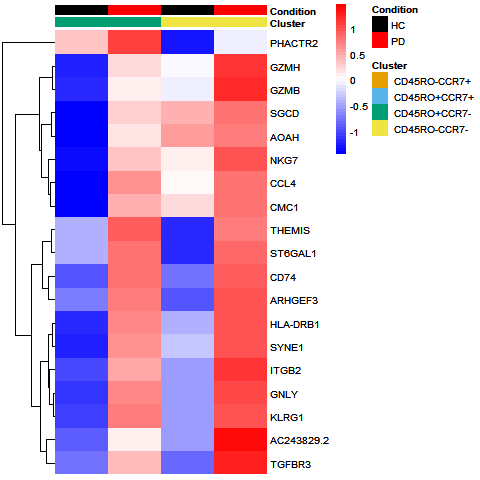

In [105]:
%%R
p <- dittoHeatmap(avg_SCT_cl,rest_Allcommon,cells.use = c(1,3,5,7),
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,"Heatmap_DEG_pct03_Upreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p 

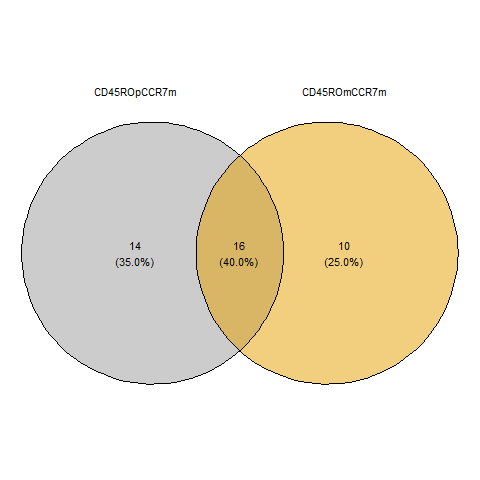

In [106]:
%%R
library(ggvenn)
x <- list( 
    CD45ROpCCR7m = rownames(CCR7mCD45ROp_pos_degs %>% filter(avg_log2FC < -0.5 &  p_val_adj <0.05)),
    CD45ROmCCR7m = rownames(CCR7mCD45ROm_pos_degs %>% filter(avg_log2FC < -0.5 &  p_val_adj <0.05))
)
p <- ggvenn(
  x, 
  fill_color = c("#999999", "#E69F00", "#56B4E9", "#009E73"),
  stroke_size = 0.5, set_name_size = 4
  )

pdf(paste0(resultdirviolin,"Venn_DEG_pct03_Downreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p 

[1] 40


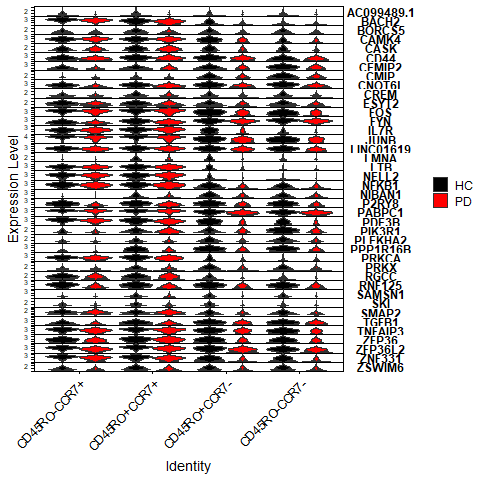

In [107]:
%%R
Allcommon <- Reduce(union,x)
print(length(Allcommon))
Idents(Subbbb) <- "CCellType"
p <- VlnPlot(Subbbb, sort(Allcommon),stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,"Violin_DEG_pct03_Downreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"),height=12)
print(p)
dev.off()
p 

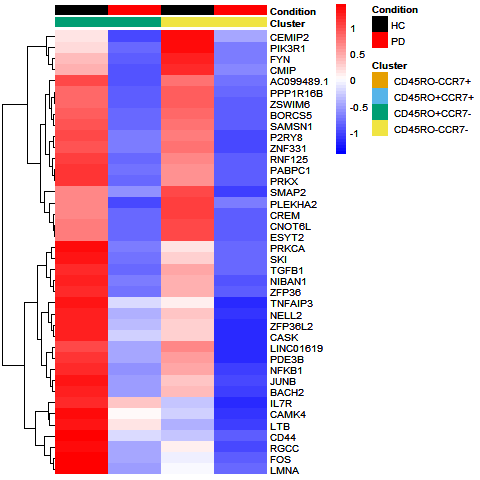

In [108]:
%%R
p <- dittoHeatmap(avg_SCT_cl,Allcommon,cells.use = c(1,3,5,7),
    annot.colors = c(dittoColors(1)[seq_len(4)],c("black","red")),
    annot.by = c("Cluster","Condition"),cluster_cols=F)

pdf(paste0(resultdirviolin,"Heatmap_DEG_pct03_Downreg_CD45ROpCCR7m_CD45ROmCCR7m.pdf"))
print(p)
dev.off()
p 

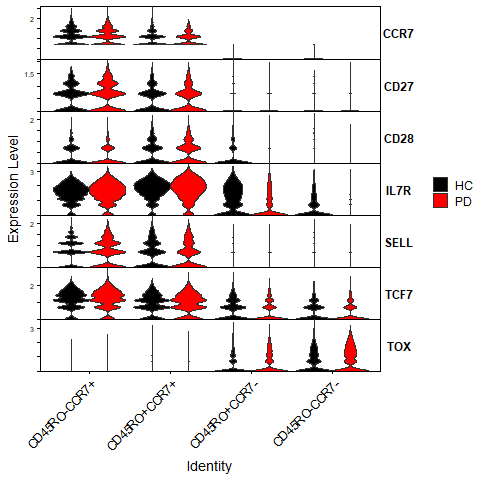

In [109]:
%%R
markers <- c("CCR7", "SELL", "CD27", "CD28", "IL7R", "SELL", "TCF7" , "TOX")
p <- VlnPlot(Subbbb, sort(markers),stack=T,split.by="Condition",cols=c("black","red"),flip=T)

pdf(paste0(resultdirviolin,
       "Violin_CCR7_SELL_CD27_CD28_IL7R_SELL_TCF7_TOX.pdf"))
plot(p)
dev.off()
p 

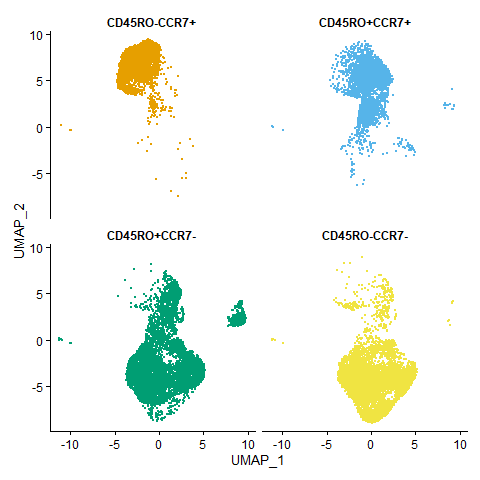

In [110]:
%%R
p <- DimPlot(Subbbb,split.by="CCellType",ncol=2,cols=c(dittoColors(1)[seq_len(4)]))+NoLegend()
pdf(paste0(resultdirviolin,
       "UMAP_splitted_celltype.pdf"))
plot(p)
dev.off()
p 

## 5, Furthermore, is there anyway to draw GSEA plots (example below) for the different KEGG OR Reactome pathways I mentioned in point 2. I think the GSEA plots seem to be very convincing.

In [39]:
%%R
pd.genes<- CCR7pCD45ROm_pos_degs %>%
  arrange(desc(avg_log2FC)) %>% 
  dplyr::select(gene , avg_log2FC )

ranks<- tibble::deframe(pd.genes)

In [42]:
%%R
library('org.Hs.eg.db')
entrzIds <- mapIds(org.Hs.eg.db, names(ranks), 'ENTREZID', 'SYMBOL')
gs <- geneset::getKEGG(org = "human",category = 'pathway')


In [44]:
%%R
gs

$geneset
            id      gene
1     hsa00010     10327
2     hsa00010       124
3     hsa00010       125
4     hsa00010       126
5     hsa00010       127
6     hsa00010       128
7     hsa00010       130
8     hsa00010    130589
9     hsa00010       131
10    hsa00010    160287
11    hsa00010      1737
12    hsa00010      1738
13    hsa00010      2023
14    hsa00010      2026
15    hsa00010      2027
16    hsa00010       217
17    hsa00010       218
18    hsa00010       219
19    hsa00010      2203
20    hsa00010       221
21    hsa00010       222
22    hsa00010       223
23    hsa00010       224
24    hsa00010       226
25    hsa00010       229
26    hsa00010       230
27    hsa00010      2538
28    hsa00010      2597
29    hsa00010     26330
30    hsa00010      2645
31    hsa00010      2821
32    hsa00010      3098
33    hsa00010      3099
34    hsa00010      3101
35    hsa00010    387712
36    hsa00010      3939
37    hsa00010      3945
38    hsa00010      3948
39    hsa00010  

In [62]:
%%R
sort(ranks)[1:5]
geneList = sort(ranks, decreasing = TRUE)


In [63]:
%%R
library(genekitr)
gse <- genGSEA(genelist = geneList, geneset = gs)


In [65]:
%%R
gs

$geneset
                                        gs_name entrez_gene
1                         HALLMARK_ADIPOGENESIS          19
2                         HALLMARK_ADIPOGENESIS       11194
3                         HALLMARK_ADIPOGENESIS       10449
4                         HALLMARK_ADIPOGENESIS          33
5                         HALLMARK_ADIPOGENESIS          34
6                         HALLMARK_ADIPOGENESIS          35
7                         HALLMARK_ADIPOGENESIS          47
8                         HALLMARK_ADIPOGENESIS          50
9                         HALLMARK_ADIPOGENESIS          51
10                        HALLMARK_ADIPOGENESIS         112
11                        HALLMARK_ADIPOGENESIS      149685
12                        HALLMARK_ADIPOGENESIS        9370
13                        HALLMARK_ADIPOGENESIS       79602
14                        HALLMARK_ADIPOGENESIS       79602
15                        HALLMARK_ADIPOGENESIS       56894
16                        HALLM

In [64]:
%%R -i projectdir
pathways <- c("HALLMARK_P53_PATHWAY", "HALLMARK_GLYCOLYSIS", "HALLMARK_DNA_REPAIR")
plotGSEA(gse, plot_type = "classic", show_pathway = pathways, show_gene = markers)



Error in plotGSEA(gse, plot_type = "classic", show_pathway = pathways,  : 
  HALLMARK_P53_PATHWAY not in GSEA result!HALLMARK_GLYCOLYSIS not in GSEA result!


RInterpreterError: Failed to parse and evaluate line 'pathways <- c("HALLMARK_P53_PATHWAY", "HALLMARK_GLYCOLYSIS", "HALLMARK_DNA_REPAIR")\nplotGSEA(gse, plot_type = "classic", show_pathway = pathways, show_gene = markers)\n'.
R error message: 'Error in plotGSEA(gse, plot_type = "classic", show_pathway = pathways,  : \n  HALLMARK_P53_PATHWAY not in GSEA result!HALLMARK_GLYCOLYSIS not in GSEA result!'

In [ ]:
%%R
colnames(CCR7pCD45ROm_pos_kegg)

 [1] "KEGG_2021_Human.Term"                
 [2] "KEGG_2021_Human.Overlap"             
 [3] "KEGG_2021_Human.P.value"             
 [4] "KEGG_2021_Human.Adjusted.P.value"    
 [5] "KEGG_2021_Human.Old.P.value"         
 [6] "KEGG_2021_Human.Old.Adjusted.P.value"
 [7] "KEGG_2021_Human.Odds.Ratio"          
 [8] "KEGG_2021_Human.Combined.Score"      
 [9] "KEGG_2021_Human.Genes"               
[10] "log10pval"                           
[11] "term"                                


In [ ]:
%%R
CCR7pCD45ROm_pos_degs[1:4,]

                 gene gene.score p_val p_val_adj diff.pct enrichment.ratio
AC099489.1 AC099489.1    2.61704     0         0   -0.249          3.73622
CFAP70         CFAP70    1.62669     0         0    0.194          3.89546
RNF125         RNF125    1.50347     0         0   -0.200          1.27548
P2RY8           P2RY8    1.42069     0         0   -0.231          1.35538
           pct.1 pct.2 avg_log2FC cluster HC_counts PD_counts    HC_norm
AC099489.1 0.091 0.340   -0.70045      HC 0.9009967 0.2003125 0.60560366
CFAP70     0.261 0.067    0.41758      PD 0.1443872 0.6044069 0.08981868
RNF125     0.726 0.926   -1.17875      HC 2.5517648 1.6466042 2.02592638
P2RY8      0.650 0.881   -1.04818      HC 2.2069738 1.3764028 1.69768203
             PD_norm
AC099489.1 0.1200883
CFAP70     0.3792665
RNF125     1.2088781
P2RY8      0.9711385


In [ ]:
%%R
library(enrichplot)
library(clusterProfiler)
library(fgsea)


pd.genes<- CCR7pCD45ROm_pos_degs %>%
  dplyr::filter(cluster == "PD") %>%
  arrange(desc(gene.score)) %>% 
  dplyr::select(gene , gene.score )

ranks<- tibble::deframe(pd.genes)

# edo2 <- gseKEGG(x$CD45ROmCCR7p, organism = "hsa", keyType = "kegg", exponent = 1, nPerm = 1000, minGSSize = 10, maxGSSize = 500, pvalueCutoff = 0.05, pAdjustMethod = "BH", verbose = TRUE, use_internal_data = FALSE, seed = FALSE)

# gseaplot(edo2, geneSetID = 1, title = "slata")




Error in dplyr::filter(., cluster == "PD") : 
  object 'CCR7pCD45ROm_pos_degs' not found


RInterpreterError: Failed to parse and evaluate line 'library(enrichplot)\nlibrary(clusterProfiler)\nlibrary(fgsea)\n\n\npd.genes<- CCR7pCD45ROm_pos_degs %>%\n  dplyr::filter(cluster == "PD") %>%\n  arrange(desc(gene.score)) %>% \n  dplyr::select(gene , gene.score )\n\nranks<- tibble::deframe(pd.genes)\n\n# edo2 <- gseKEGG(x$CD45ROmCCR7p, organism = "hsa", keyType = "kegg", exponent = 1, nPerm = 1000, minGSSize = 10, maxGSSize = 500, pvalueCutoff = 0.05, pAdjustMethod = "BH", verbose = TRUE, use_internal_data = FALSE, seed = FALSE)\n\n# gseaplot(edo2, geneSetID = 1, title = "slata")\n\n'.
R error message: 'Error in dplyr::filter(., cluster == "PD") : \n  object \'CCR7pCD45ROm_pos_degs\' not found'

In [ ]:
%%R
ranks

   [1] 1.62669 1.33506 0.93616 0.84689 0.75566 0.73703 0.73517 0.70530 0.70432
  [10] 0.69915 0.64659 0.60809 0.59959 0.59698 0.58560 0.57644 0.57511 0.56379
  [19] 0.56317 0.55805 0.54621 0.53748 0.53620 0.53274 0.52242 0.50800 0.50279
  [28] 0.49304 0.46916 0.46850 0.46824 0.45069 0.44958 0.44395 0.44361 0.44254
  [37] 0.43608 0.43378 0.43305 0.43162 0.42882 0.42317 0.42170 0.41607 0.41566
  [46] 0.41300 0.41280 0.41277 0.40810 0.40763 0.40136 0.39612 0.39436 0.39274
  [55] 0.38244 0.38223 0.37863 0.37754 0.37546 0.37291 0.36328 0.36323 0.36179
  [64] 0.35880 0.35800 0.35415 0.35396 0.35003 0.34708 0.34701 0.34585 0.34367
  [73] 0.34362 0.34210 0.34068 0.33899 0.33788 0.33662 0.33486 0.33309 0.33142
  [82] 0.33029 0.32903 0.32764 0.32546 0.32263 0.32127 0.32029 0.31904 0.31880
  [91] 0.31804 0.31801 0.31614 0.31483 0.31321 0.31317 0.31200 0.30973 0.30930
 [100] 0.30862 0.30769 0.30599 0.30485 0.30124 0.30100 0.30084 0.30063 0.29840
 [109] 0.29836 0.29835 0.29771 0.29629 0.29494 0.293

In [ ]:
%%R
library('org.Hs.eg.db')
entrzIds <- mapIds(org.Hs.eg.db, names(ranks), 'ENTREZID', 'SYMBOL')

pathways <- reactomePathways(entrzIds)
plotEnrichment(pathways[["RUNX1 regulates transcription of genes involved in differentiation of myeloid cells"]],
               entrzIds) + labs(title="Programmed Cell Death")


Error in mapIds_base(x, keys, column, keytype, ..., multiVals = multiVals) : 
  object 'ranks' not found


RInterpreterError: Failed to parse and evaluate line 'library(\'org.Hs.eg.db\')\nentrzIds <- mapIds(org.Hs.eg.db, names(ranks), \'ENTREZID\', \'SYMBOL\')\n\npathways <- reactomePathways(entrzIds)\nplotEnrichment(pathways[["RUNX1 regulates transcription of genes involved in differentiation of myeloid cells"]],\n               entrzIds) + labs(title="Programmed Cell Death")\n'.
R error message: "Error in mapIds_base(x, keys, column, keytype, ..., multiVals = multiVals) : \n  object 'ranks' not found"

In [41]:
%%R
pathways[["RUNX1 regulates transcription of genes involved in differentiation of myeloid cells"]]

[1] "860" "861" "865"


In [44]:
%%R
entrzIds <- mapIds(org.Hs.eg.db, names(ranks), 'ENTREZID', 'SYMBOL')

# entrzIds

In [45]:
%%R
entrzIds

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'NoneType'>'

In [ ]:
RUNX1 Regulates Transcription Of Genes Involved In Differentiation Of Myeloid Cells R-HSA-8939246